In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split

import dgl
from dgl import function as fn
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh

import networkx as nx
import matplotlib.pyplot as plt
import random as rand
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from collections import defaultdict

In [2]:

#set gpu if available
if th.cuda.is_available():
    print("GPU is available")
    #device = th.device("cuda")
    device = th.device("cuda")
else:
    print("GPU not available, CPU used")
    device = th.device("cpu")

GPU is available


In [3]:
#operation for neigbors
class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        if self.activation is not None:
            h = self.activation(h)
        return {'h' : h}
    
#gcn layer in network
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.pull(g.nodes())
        g.apply_nodes(self.apply_mod)
        
        return g.ndata.pop('h')
    
#network
class LIGN(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(LIGN, self).__init__()
        self.gcn1 = GCN(in_feats, 100, F.relu)
        self.gcn2 = GCN(100, 30, F.relu)
        self.gcn3 = GCN(30, out_feats, th.tanh)

    def forward(self, g, features):
        x = self.gcn1(g, features)
        x = self.gcn2(g, x)
        
        return self.gcn3(g, x)


In [4]:
#loss function

def similarity_matrix(x): #pairwise distance
    """x_norm = (x**2).sum(1).view(-1, 1)
    y = x
    y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2.0 * th.mm(x, th.transpose(y, 0, 1))"""
    n = x.size(0)
    d = x.size(1)

    y = x.unsqueeze(0).expand(n, n, d)
    x = x.unsqueeze(1).expand(n, n, d)
    
    dist = th.pow(x - y, 2).sum(2)
    
    return dist

def same_label(y):
    s = y.size(0)
    y_expand = y.unsqueeze(0).expand(s, s)
    Y = y_expand.eq(y_expand.t())
    return Y

def pairwaise_loss(output, labels):
    """
    if nodes with the same label: x^2
    if nodes with different label: -x^2
    """
    sim = similarity_matrix(output)
    temp = same_label(labels)
    temp_inv = temp*(-1) + 1
    
    same_l = (temp * sim)
    same_l_inv = (temp_inv * sim)
    loss = (th.sum(same_l)/th.sum(temp))**2 - (th.sum(same_l_inv)/th.sum(temp_inv))**2
    
    return loss

def has_1_rand_label(nodes): return (nodes.data['t_labels'] == possible_lab[0]).squeeze(0)

def filter_knn_label(nodes): return (nodes.data['t_labels'] == curr_used_lab).squeeze(0)



In [5]:
#load CORA dataset
data = citegrh.load_cora()
ds_features = th.FloatTensor(data.features).to(device) #convert to pytorch data type and add to cpu/gpu
ds_labels = th.LongTensor(data.labels).to(device)
ds_g = data.graph

# add self loop for the sum of festures
ds_g.remove_edges_from(nx.selfloop_edges(ds_g))
ds_g = DGLGraph(ds_g)
ds_g.add_edges(ds_g.nodes(), ds_g.nodes())
ds_g.ndata['features'] = ds_features
ds_g.ndata['t_labels'] = ds_labels #used to filter and train the first two labels, not needed for prediction

# to coordinate sending of features over the graph network
m_func = fn.copy_src(src='h', out='m')
m_reduce_func = fn.sum(msg='m', out='h')

In [6]:
#load MNIST dataset



In [7]:
########### Create Model ############

# hyper parameters
DIST_VEC_SIZE = 10
NUMBER_OF_LABELS = th.unique(ds_g.ndata["t_labels"]).size(0)
k_NEIGHBOR = 3
EPOCH = 50
INIT_NUM_LAB = 3 #must be at least 1
Lambda = 0.0001

model = LIGN(ds_features.size()[1], DIST_VEC_SIZE).to(device)

knn = KNeighborsClassifier(n_neighbors=k_NEIGHBOR)
opt = th.optim.Adam(model.parameters(), lr=1e-3)# only run once

In [8]:
#training

train_g = ds_g.subgraph(ds_g.nodes()[:int(len(ds_g) * 1)])#100 percent of all the nodes
train_g.copy_from_parent()

labeled_nodes = th.LongTensor([])
for i in range(NUMBER_OF_LABELS):
    def has_feature_one(nodes): return (nodes.data['t_labels'] == i).squeeze(0)
    
    filt = train_g.filter_nodes(has_feature_one)
    labeled_nodes = th.cat((filt[:k_NEIGHBOR+10], labeled_nodes), -1)
    

labeled_g = train_g.subgraph(labeled_nodes) #labels nodes in 
labeled_g.copy_from_parent()

"""#both dataset should include all labels
while th.unique(train_g.ndata["t_labels"]).size(0) != th.unique(labeled_g.ndata["t_labels"]).size(0):
    c=th.randperm(len(ds_g.nodes())) #shuffle
    ds_g.nodes =ds_g.nodes()[c]
    
    train_g = ds_g.subgraph(ds_g.nodes()[:int(len(ds_g) * 1)])#100 percent of all the nodes
    labeled_g = ds_g.subgraph(ds_g.nodes()[int(len(ds_g) * .20):]) #20 percent labeled nodes for knn
    train_g.copy_from_parent()
    labeled_g.copy_from_parent()"""


possible_lab = list(range(NUMBER_OF_LABELS))
rand.shuffle(possible_lab) #set random order for how labels are added

used_lab = []
curr_used_lab = 0

EPOCH_SIZE = 0


model.train()

#############train with 2 labels of 7 labels (uses true label from the dataset), assign vector to each node,
            #knn (1 labeled node for each label), test
selected_nodes = train_g.filter_nodes(has_1_rand_label) #add two unseen labels
used_lab.append(possible_lab.pop(0))
for i in range(INIT_NUM_LAB - 1):
    selected_nodes = th.cat((train_g.filter_nodes(has_1_rand_label), selected_nodes), -1)
    used_lab.append(possible_lab.pop(0))

c=th.randperm(len(selected_nodes)) #shuffle
selected_nodes=selected_nodes[c]

EPOCH_SIZE = int(len(selected_nodes)*.80)

#train
addon_layer = GCN(DIST_VEC_SIZE, NUMBER_OF_LABELS, None).to(device) #extra layer 
for epoch in range(EPOCH):
    print("> " + str(epoch))
    c=th.randperm(len(selected_nodes)) #shuffle
    selected_nodes=selected_nodes[c]
    
    epoch_nodes = selected_nodes[:EPOCH_SIZE] #selected 20% of random nodes to train with at each epoch
    
    error = []
    for count in range(int(len(epoch_nodes)*.7), len(epoch_nodes)):
        sub_graph = train_g.subgraph(epoch_nodes[:count])
        sub_graph.copy_from_parent()
        sub_graph.register_message_func(m_func)
        sub_graph.register_reduce_func(m_reduce_func)
        
        feats = sub_graph.ndata['features']
        labs = sub_graph.ndata['t_labels'] #true label
        
        out = model(sub_graph, feats)
        
        out2 = addon_layer(sub_graph, out) #extra layer
        out2 = th.log_softmax(out2, 1)
        
        loss = Lambda*pairwaise_loss(out, labs) + F.nll_loss(out2, labs)
        error.append(loss.item())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    #print(np.mean(error))

    
#knn and assign vector
sub_tra_graph = train_g.subgraph(selected_nodes)
sub_tra_graph.copy_from_parent()
sub_tra_graph.register_message_func(m_func)
sub_tra_graph.register_reduce_func(m_reduce_func)

##labeled graph knn
out_nodes = th.LongTensor([])
for n in used_lab:
    curr_used_lab = n
    out_nodes = th.cat((labeled_g.filter_nodes(filter_knn_label), out_nodes), -1)

c=th.randperm(len(out_nodes)) #shuffle
out_nodes=out_nodes[c]

sub_labeled_graph = labeled_g.subgraph(out_nodes)
sub_labeled_graph.copy_from_parent()
sub_labeled_graph.register_message_func(m_func)
sub_labeled_graph.register_reduce_func(m_reduce_func)

knn.fit(model(sub_labeled_graph, sub_labeled_graph.ndata['features']).cpu().detach().numpy(), sub_labeled_graph.ndata['t_labels'].cpu().detach().numpy())
sub_tra_graph.ndata['p_labels'] = th.LongTensor(knn.predict(model(sub_tra_graph, sub_tra_graph.ndata['features']).cpu().detach().numpy())).to(device)

print((sub_tra_graph.ndata['t_labels']).cpu().detach().numpy())
print((sub_tra_graph.ndata['p_labels']).detach().cpu().numpy())

#test
print(f"> Initial training with {INIT_NUM_LAB} labels (distinction efficiency): {metrics.accuracy_score((sub_tra_graph.ndata['t_labels']).cpu().detach().numpy(), (sub_tra_graph.ndata['p_labels']).detach().cpu().numpy())}")



> 0
> 1
> 2
> 3
> 4
> 5
> 6
> 7
> 8
> 9
> 10
> 11
> 12
> 13
> 14
> 15
> 16
> 17
> 18
> 19
> 20
> 21
> 22
> 23
> 24
> 25
> 26
> 27
> 28
> 29
> 30
> 31
> 32
> 33
> 34
> 35
> 36
> 37
> 38
> 39
> 40
> 41
> 42
> 43
> 44
> 45
> 46
> 47
> 48
> 49
[6 4 4 5 4 5 6 6 6 5 5 6 6 4 5 4 4 5 4 5 5 5 6 5 6 6 6 5 6 4 5 4 6 6 5 5 4
 4 4 6 6 4 6 6 4 4 4 6 5 4 5 4 4 4 6 4 6 4 5 5 4 4 5 5 6 6 6 6 5 5 6 6 4 4
 5 4 4 5 6 6 4 6 5 6 5 6 5 6 6 4 5 4 6 5 4 5 6 4 6 4 4 4 6 4 5 4 6 6 4 6 6
 4 6 5 4 5 6 6 4 6 6 4 6 5 5 6 5 6 6 4 6 5 4 6 6 6 6 6 6 6 6 6 5 5 6 4 4 4
 5 6 6 5 6 4 6 6 6 4 4 6 6 6 6 6 4 5 6 4 6 5 4 4 5 5 5 5 6 6 6 6 4 6 6 6 6
 4 4 6 6 6 6 5 6 5 4 5 4 6 6 5 4 6 6 6 6 6 6 6 6 4 6 4 5 6 5 5 4 6 4 5 6 4
 6 6 6 5 6 5 5 6 6 5 6 4 6 6 4 4 6 6 6 5 5 4 6 4 5 6 6 5 6 5 6 6 4 6 6 4 6
 5 4 6 4 6 6 6 6 6 5 4 6 6 6 6 6 6 6 5 4 5 6 4 4 5 4 6 5 4 4 6 6 5 6 6 4 6
 5 5 4 5 5 4 6 4 6 6 6 4 6 6 6 6 4 4 4 6 4 4 5 6 4 5 6 4 6 6 4 6 4 4 4 6 5
 6 4 5 4 6 5 4 5 6 5 4 5 5 6 6 6 6 5 4 4 6 4 6 4 5 4 4 4 5 5 6 5 6 4 6 6 4
 5 6 4 6 6

In [9]:
  
#training 
#######################add label, assign vector to each node, knn, test and train (with predicted labels by knn)

while len(possible_lab) > 0: #do it for every unseen label
    selected_nodes = th.cat((train_g.filter_nodes(has_1_rand_label), selected_nodes), -1)
    used_lab.append(possible_lab.pop(0))
    
    c=th.randperm(len(selected_nodes)) #shuffle
    selected_nodes=selected_nodes[c]
    
    #assign vector
    
    #########
    sub_tra_graph = train_g.subgraph(selected_nodes)
    sub_tra_graph.copy_from_parent()
    sub_tra_graph.register_message_func(m_func)
    sub_tra_graph.register_reduce_func(m_reduce_func)

    ##labeled graph knn
    out_nodes = th.LongTensor([])
    for n in used_lab:
        curr_used_lab = n
        out_nodes = th.cat((labeled_g.filter_nodes(filter_knn_label), out_nodes), -1)

    c=th.randperm(len(out_nodes)) #shuffle
    out_nodes=out_nodes[c]

    sub_labeled_graph = labeled_g.subgraph(out_nodes)
    sub_labeled_graph.copy_from_parent()
    sub_labeled_graph.register_message_func(m_func)
    sub_labeled_graph.register_reduce_func(m_reduce_func)

    knn.fit(model(sub_labeled_graph, sub_labeled_graph.ndata['features']).cpu().detach().numpy(), sub_labeled_graph.ndata['t_labels'].cpu().detach().numpy())
    sub_tra_graph.ndata['p_labels'] = th.LongTensor(knn.predict(model(sub_tra_graph, sub_tra_graph.ndata['features']).cpu().detach().numpy())).to(device)
    train_g.nodes[sub_tra_graph.parent_nid].data['p_labels'] = sub_tra_graph.ndata['p_labels']
    
    #test
    print(f"After new label added and before retraining (total: {len(used_lab)}), accuracy of all nodes: {metrics.accuracy_score((sub_tra_graph.ndata['t_labels']).cpu().detach().numpy(), (sub_tra_graph.ndata['p_labels']).detach().cpu().numpy())}")
    #########
    
    addon_layer = GCN(DIST_VEC_SIZE, NUMBER_OF_LABELS, None).to(device) #extra layer 
    for epoch in range(EPOCH):
        print("> " + str(epoch))
        c=th.randperm(len(selected_nodes)) #shuffle
        selected_nodes=selected_nodes[c]
        epoch_nodes = selected_nodes[:EPOCH_SIZE] #select 20% of random nodes to train with at each epoch

        error = []
        for count in range(int(len(epoch_nodes)*.7), len(epoch_nodes)):
            sub_graph = train_g.subgraph(epoch_nodes[:count])
            sub_graph.copy_from_parent()
            sub_graph.register_message_func(m_func)
            sub_graph.register_reduce_func(m_reduce_func)

            feats = sub_graph.ndata['features']
            labs = sub_graph.ndata['p_labels'] #true label

            out = model(sub_graph, feats)
            out2 = addon_layer(sub_graph, out) #extra layer
            out2 = th.log_softmax(out2, 1)

            loss = Lambda*pairwaise_loss(out, labs) + F.nll_loss(out2, labs)
            error.append(loss.item())

            opt.zero_grad()
            loss.backward()
            opt.step()

sub_tra_graph = train_g.subgraph(selected_nodes)
sub_tra_graph.copy_from_parent()
sub_tra_graph.register_message_func(m_func)
sub_tra_graph.register_reduce_func(m_reduce_func)

##labeled graph knn
out_nodes = th.LongTensor([])
for n in used_lab:
    curr_used_lab = n
    out_nodes = th.cat((labeled_g.filter_nodes(filter_knn_label), out_nodes), -1)

c=th.randperm(len(out_nodes)) #shuffle
out_nodes=out_nodes[c]

sub_labeled_graph = labeled_g.subgraph(out_nodes)
sub_labeled_graph.copy_from_parent()
sub_labeled_graph.register_message_func(m_func)
sub_labeled_graph.register_reduce_func(m_reduce_func)

knn.fit(model(sub_labeled_graph, sub_labeled_graph.ndata['features']).cpu().detach().numpy(), sub_labeled_graph.ndata['t_labels'].cpu().detach().numpy())
sub_tra_graph.ndata['p_labels'] = th.LongTensor(knn.predict(model(sub_tra_graph, sub_tra_graph.ndata['features']).cpu().detach().numpy())).to(device)
train_g.nodes[sub_tra_graph.parent_nid].data['p_labels'] = sub_tra_graph.ndata['p_labels']

#test
print(f"After new label added and after retraining (total: {len(used_lab)}), accuracy of all nodes: {metrics.accuracy_score((sub_tra_graph.ndata['t_labels']).cpu().detach().numpy(), (sub_tra_graph.ndata['p_labels']).detach().cpu().numpy())}")

After new label added and before retraining (total: 4), accuracy of all nodes: 0.5951972555746141
> 0
> 1
> 2
> 3
> 4
> 5
> 6
> 7
> 8
> 9
> 10
> 11
> 12
> 13
> 14
> 15
> 16
> 17
> 18
> 19
> 20
> 21
> 22
> 23
> 24
> 25
> 26
> 27
> 28
> 29
> 30
> 31
> 32
> 33
> 34
> 35
> 36
> 37
> 38
> 39
> 40
> 41
> 42
> 43
> 44
> 45
> 46
> 47
> 48
> 49
After new label added and before retraining (total: 5), accuracy of all nodes: 0.43027638190954776
> 0
> 1
> 2
> 3
> 4
> 5
> 6
> 7
> 8
> 9
> 10
> 11
> 12
> 13
> 14
> 15
> 16
> 17
> 18
> 19
> 20
> 21
> 22
> 23
> 24
> 25
> 26
> 27
> 28
> 29
> 30
> 31
> 32
> 33
> 34
> 35
> 36
> 37
> 38
> 39
> 40
> 41
> 42
> 43
> 44
> 45
> 46
> 47
> 48
> 49
After new label added and before retraining (total: 6), accuracy of all nodes: 0.23319502074688797
> 0
> 1
> 2
> 3
> 4
> 5
> 6
> 7
> 8
> 9
> 10
> 11
> 12
> 13
> 14
> 15
> 16
> 17
> 18
> 19
> 20
> 21
> 22
> 23
> 24
> 25
> 26
> 27
> 28
> 29
> 30
> 31
> 32
> 33
> 34
> 35
> 36
> 37
> 38
> 39
> 40
> 41
> 42
> 43
> 44
> 45
> 46

In [10]:
j = th.LongTensor([2, 4, 2, 8, 4])
p = th.FloatTensor([[1, 2.1],
                  [3, 5],
                  [5, 4],
                  [7, 9],
                  [1.0, -1.0]])

m = same_label(j)
n = similarity_matrix(p)
print(m)
print(n)
print(m*n)
print((m*-1 + 1)*n)

tensor([[ True, False,  True, False, False],
        [False,  True, False, False,  True],
        [ True, False,  True, False, False],
        [False, False, False,  True, False],
        [False,  True, False, False,  True]])
tensor([[  0.0000,  12.4100,  19.6100,  83.6100,   9.6100],
        [ 12.4100,   0.0000,   5.0000,  32.0000,  40.0000],
        [ 19.6100,   5.0000,   0.0000,  29.0000,  41.0000],
        [ 83.6100,  32.0000,  29.0000,   0.0000, 136.0000],
        [  9.6100,  40.0000,  41.0000, 136.0000,   0.0000]])
tensor([[ 0.0000,  0.0000, 19.6100,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, 40.0000],
        [19.6100,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 40.0000,  0.0000,  0.0000,  0.0000]])
tensor([[  0.0000,  12.4100,   0.0000,  83.6100,   9.6100],
        [ 12.4100,   0.0000,   5.0000,  32.0000,   0.0000],
        [  0.0000,   5.0000,   0.0000,  29.0000,  41.0000],
        [ 83.6100

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
total: 7, accuracy of all nodes: 0.34
tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.9982,  1.0000, -0.9999,
          0.9995, -1.0000],
        [-0.9990,  1.0000,  1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000,
         -1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.9997,  1.0000, -0.9998,
          0.9999, -1.0000],
        [-1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000,
         -1.0000,  1.0000],
        [-0.7579,  1.0000,  1.0000,  1.0000, -0.9950, -1.0000,  1.0000, -1.0000,
         -1.0000,  0.9999],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  0.9997, -1.0000,  1.0000, -1.0000,
         -1.0000, -0.9979],
        [ 1.0000,  1.0000,  1.0000,  

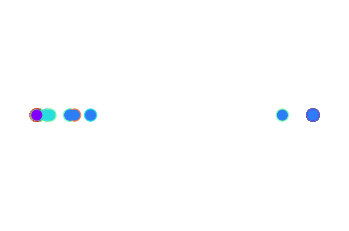

In [11]:
num_look = 100

sub_graph1 = train_g.subgraph(selected_nodes[:num_look])
sub_graph1.copy_from_parent()
sub_graph1.register_message_func(m_func)
sub_graph1.register_reduce_func(m_reduce_func)

sub_graph2 = labeled_g.subgraph(out_nodes)
sub_graph2.copy_from_parent()
sub_graph2.register_message_func(m_func)
sub_graph2.register_reduce_func(m_reduce_func)

print(sub_graph2.ndata['features'])

knn.fit(model(sub_graph2, sub_graph2.ndata['features']).cpu().detach().numpy(), sub_graph2.ndata['t_labels'].cpu().detach().numpy())
sub_graph1.ndata['p_labels'] = th.LongTensor(knn.predict(model(sub_graph1, sub_graph1.ndata['features']).cpu().detach().numpy())).to(device)

print(f"total: {len(used_lab)}, accuracy of all nodes: {metrics.accuracy_score((sub_graph1.ndata['t_labels']).cpu().detach().numpy(), (sub_graph1.ndata['p_labels']).detach().cpu().numpy())}")

feats = sub_graph1.ndata['features']
labs = sub_graph1.ndata['t_labels'] #true label
output = model(sub_graph1, feats)
print(output)
print(labs)


pos = defaultdict(list)
cos = []
cos2 = []

for n in range(num_look):
    pos[n] = (output[n][0].item(), output[n][1].item())
    cos.append(sub_graph1.ndata['p_labels'][n].item())
    cos2.append(sub_graph1.ndata['t_labels'][n].item())

nx.draw_networkx_nodes(sub_graph1.to_networkx(), pos, node_color=cos2, cmap=plt.get_cmap('rainbow'), vmin = float(ds_labels.min().item()), vmax = float(ds_labels.max().item()), node_size=150)
nx.draw(sub_graph1.to_networkx(), pos, node_color=cos, cmap=plt.get_cmap('rainbow'), vmin = float(ds_labels.min().item()), vmax = float(ds_labels.max().item()), node_size=100)

In [12]:
th.any(th.isnan(sub_labeled_graph.ndata['features']))
th.all(th.isfinite(sub_labeled_graph.ndata['features']))

tensor(True, device='cuda:0')